In [1]:
import sys
import os

from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. '/Users/darren/Documents/CSE493G1/GuitarTransformer/'
FOLDERNAME = 'drive/MyDrive/project/GuitarTransformer'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Add the root directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

print(os.getcwd())

%cd $FOLDERNAME

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content
/content/drive/MyDrive/project/GuitarTransformer


In [2]:
! pip3 install -r pip-requirement.txt

In [3]:
# model definition, seq2seq stateful lstm for real-time audio processing

import math
import torch
import torch.optim as optim
import torch.nn as nn

class AudioLSTM(nn.Module):
  def __init__(self, input_size, output_size, hidden_size, skip=1, num_layers=1):
    super(AudioLSTM, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.skip = skip

    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)

    # needed for stateful LSTM
    self.hidden = None  # (hidden state, cell state)

  def forward(self, x):
    """
    :param x: tensor of shape (batch_size, seq_length, features)
    """
    if self.hidden is None:
      self.hidden = (
        torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device),
        torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
      )

    out, self.hidden = self.lstm(x, self.hidden)

    out = self.fc(out)

    # add residual step
    if self.skip:
      out += x[:, :, :]

    return out

  def reset_hidden(self):
    self.hidden = None

  # detach hidden state, this resets gradient tracking on the hidden state
  def detach_hidden(self):
    if self.hidden.__class__ == tuple:
      self.hidden = tuple([h.clone().detach() for h in self.hidden])
    else:
      self.hidden = self.hidden.clone().detach()

  def train_epoch(self, input_data, target_data, loss_fcn, optim, bs, init_len=200, up_fr=1000):
    """
    :param input_data: x examples with shape (num_examples, seq_length, features)
    :param target_data: y target with shape (num_examples, seq_length, features)
    :param loss_fcn: our loss function
    :param optim: our optimizer
    :param bs: batch size, number of examples per batch
    :param init_len: number of audio samples to initialize hidden state
    :param up_fr: number of timesteps before we backprop (truncated backprop)
    """
    # shuffle the examples around
    shuffle = torch.randperm(input_data.shape[0])

    # Iterate over the batches
    ep_loss = 0
    for batch_i in range(math.ceil(shuffle.shape[0] / bs)):
      # Load batch of shuffled segments
      input_batch = input_data[shuffle[batch_i * bs:(batch_i + 1) * bs], :, :]
      target_batch = target_data[shuffle[batch_i * bs:(batch_i + 1) * bs],:, :]

      # Initialise network hidden state by processing some samples then zero the gradient buffers
      self(input_batch[:, 0:init_len, :])
      self.zero_grad()

      # Choose the starting index for processing the rest of the batch sequence, in chunks of args.up_fr
      start_i = init_len
      batch_loss = 0
      k = 0
      # Iterate over the remaining samples in the mini batch
      for k in range(math.ceil((input_batch.shape[1] - init_len) / up_fr)):
        # Process input batch with neural network
        output = self(input_batch[:, start_i:start_i + up_fr, :])

        # Calculate loss and update network parameters
        loss = loss_fcn(output, target_batch[:, start_i:start_i + up_fr, :])
        loss.backward()
        optim.step()

        # Set the network hidden state, to detach it from the computation graph
        self.detach_hidden()
        self.zero_grad()

        # Update the start index for the next iteration and add the loss to the batch_loss total
        start_i += up_fr
        batch_loss += loss

      # Add the average batch loss to the epoch loss and reset the hidden states to zeros
      ep_loss += batch_loss / (k + 1)
      self.reset_hidden()

    return ep_loss / (batch_i + 1)

  def process_data(self, input_data, target_data, loss_function, chuck_size):
    """
    :param input_data: x examples with shape (num_examples, seq_length, features)
    :param target_data: y target with shape (num_examples, seq_length, features)
    :param loss_fcn: our loss function
    :param chuck_size: the number of seq_length to process one time (avoid memory issue)
    """

    with torch.no_grad():
        # calculate the number of processing
        frame_len = target_data.size()[1]
        chuck_num = math.ceil(frame_len / chuck_size)

        # create empty output tensor
        output = torch.empty_like(target_data)

        # Iterate over chucks and process the input audio
        for l in range(chuck_num):
            # forward the input
            if l == chuck_num - 1: # the last loop
                output[:, l * chuck_size:, :] = self(input_data[:, l * chuck_size:, :])
            else: # before the last loop
                output[:, l * chuck_size:(l + 1) * chuck_size, :] = self(input_data[:, l * chuck_size:(l + 1) * chuck_size, :])
            self.detach_hidden()
        self.reset_hidden()

        # calucate the loss
        loss = loss_function(output, target_data)
    return output, loss


In [4]:
import audio

# load data
def audio_preprocessing(amplifier='ht1', data_type='train', frame_len=1):

    assert amplifier in ('ht1', 'muff') , "Amplifier should be either ht1 or muff"
    assert data_type in ('train', 'val', 'test') , "data_type should be either train , val or test"

    input_loc = f'./data/{data_type}/{amplifier}-input.wav'
    target_loc = f'./data/{data_type}/{amplifier}-target.wav'

    input_waveform = audio.load_audio(input_loc)
    target_waveform = audio.load_audio(target_loc)

    input_frames = audio.framify(input_waveform, frame_len)
    target_frames = audio.framify(target_waveform, frame_len)

    if data_type == 'train':
        seq_length = 44100
        X = audio.split_data(input_frames, seq_length)
        y = audio.split_data(target_frames, seq_length)

    else:
        frame_len = input_frames.shape[0]
        seq_length = frame_len//1
        X = audio.split_data(input_frames, seq_length)
        y = audio.split_data(target_frames, seq_length)

    return X, y

X_train, y_train = audio_preprocessing(amplifier='ht1', data_type='train')
X_val, y_val = audio_preprocessing(amplifier='ht1', data_type='val')
X_test, y_test = audio_preprocessing(amplifier='ht1', data_type='test')


In [5]:
print('training:', X_train.shape, y_train.shape)
print('validation: ', X_val.shape, y_val.shape)
print('test: ', X_test.shape, y_test.shape)

training: torch.Size([340, 44100, 2]) torch.Size([340, 44100, 2])
validation:  torch.Size([1, 2251753, 2]) torch.Size([1, 2251753, 2])
test:  torch.Size([1, 2646001, 2]) torch.Size([1, 2646001, 2])


In [6]:
import numpy as np
import random

# model params
input_size = 2  # num features, 2 for stereo
output_size = 2  # num features, 2 for stereo
hidden_size = 16  # hidden state size
skip_con = 1  # is there a skip connection?

# train params
batch_size = 10  # num examples per batch
init_len = 200  # num frames to process without backprop to init hidden state
up_fr = 1000  # num frames for truncated backprop

# hyperparams
learn_rate = 1e-2

network = AudioLSTM(input_size=input_size, hidden_size=hidden_size,
                                     output_size=output_size, skip=skip_con)

if not torch.cuda.is_available():
    print('cuda device not available/not selected')
    cuda = 0
else:
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    torch.cuda.set_device(0)
    print('cuda device available')
    network = network.cuda()
    cuda = 1


# Set up training optimiser + scheduler + loss fcns and training info tracker
optimiser = optim.Adam(network.parameters(), lr=learn_rate, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimiser, 'min', factor=0.5, patience=5, verbose=True)
loss_functions = nn.SmoothL1Loss()

cuda device not available/not selected


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [7]:
# TODO: train the model
import time
from collections import defaultdict
import copy

res = defaultdict(list)
best_val_loss = float('inf')
best_model = None
best_ind = -1

# Train epochs
for epoch in range(10):

    ep_st_time = time.time()
    # train in training
    epoch_loss = network.train_epoch(X_train, y_train, loss_functions, optimiser, batch_size, init_len, up_fr)
    ep_end_time = time.time()

    val_st_time = time.time()
    # check validation result
    output, val_loss = network.process_data(X_val, y_val, loss_functions, chuck_size=1000)
    val_end_time = time.time()

    # save best model
    if val_loss < best_val_loss :
      best_model = copy.deepcopy(network)
      best_val_loss = val_loss
      best_ind = epoch

    res['epoch'].append(epoch+1)
    res['training_loss'].append(epoch_loss.item())
    res['training_time'].append(ep_end_time - ep_st_time)
    res['val_loss'].append(val_loss.item())
    res['val_time'].append(val_end_time - val_st_time)

    print(f"Epoch {epoch + 1}, Loss: {epoch_loss: .8f}, Val Loss: {val_loss: .8f}")


Epoch 1, Loss:  0.03159621, Val Loss:  0.02325991
Epoch 2, Loss:  0.02748657, Val Loss:  0.01896558
Epoch 3, Loss:  0.02163554, Val Loss:  0.01814261
Epoch 4, Loss:  0.01903429, Val Loss:  0.01941779
Epoch 5, Loss:  0.01752382, Val Loss:  0.01645016
Epoch 6, Loss:  0.01707629, Val Loss:  0.01514145
Epoch 7, Loss:  0.01682725, Val Loss:  0.01518101
Epoch 8, Loss:  0.01668376, Val Loss:  0.01515880
Epoch 9, Loss:  0.01690171, Val Loss:  0.01601221
Epoch 10, Loss:  0.01673627, Val Loss:  0.01554443


In [8]:
import pandas as pd
res_table = pd.DataFrame(res)

training_time = res_table['training_time'].sum()
print(f'training_time for 10 epoch: {training_time} sec')

res_table

training_time for 10 epoch: 326.69523668289185 sec


,epoch,training_loss,training_time,val_loss,val_time
0,1,0.031596,36.459162,0.023260,3.699436
1,2,0.027487,32.286070,0.018966,3.730533
2,3,0.021636,32.741826,0.018143,5.687323
3,4,0.019034,30.801023,0.019418,3.709452
4,5,0.017524,31.814590,0.016450,5.239645
5,6,0.017076,34.835481,0.015141,3.800897
6,7,0.016827,31.906189,0.015181,5.501397
7,8,0.016684,32.070207,0.015159,3.801650
8,9,0.016902,31.764324,0.016012,5.158183
9,10,0.016736,32.016364,0.015544,3.753959


In [10]:
test_st_time = time.time()
output, test_loss = best_model.process_data(X_test, y_test, loss_functions, chuck_size=1000)
test_end_time = time.time()
print(f'test loss: {test_loss:.6f}')
print(f'test time: {test_end_time - test_st_time} sec')

test loss: 0.025232
test time: 5.64190149307251 sec


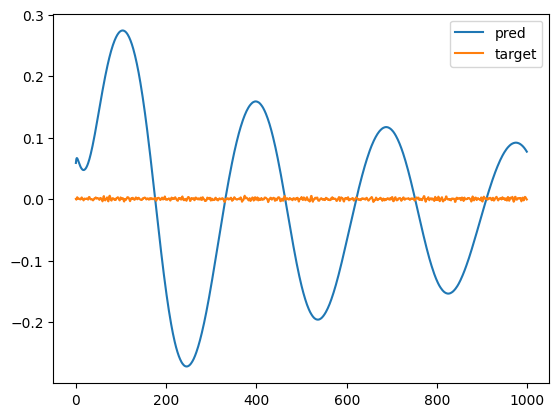

In [23]:
# Compare predict and target
import matplotlib.pyplot as plt

# sample first 1000 audio data
y_test_pred = output[0, :, 0][:1000]
y_test_true = y_test[0, :, 0][:1000]
plt.plot(range(len(y_test_pred)), y_test_pred, label='pred')
plt.plot(range(len(y_test_true)), y_test_true, label='target')
plt.legend()

In [24]:
import torchaudio

filepath = "result/ht1_target_predict.wav"
output1 = output[0]
torchaudio.save(filepath, output1, sample_rate=44100, channels_first=False)